## [Moreau et al. (2021)](https://hal.archives-ouvertes.fr/hal-03346165/document)
### What is done:
* delete unlabeled data
* join car and taxi into one category
* delete unwanted labels
* compute speed and acceleration
* remove unrealistic data points
<img src="Tresholds for transport modes.PNG" width="800" height="400">
* interpolate linearly the data points (T=2s)
* merge all users and divide into trips ($\Delta$t <= 20min)
* splitting trips: 
 * 64% training
 * 16% validation
 * 20% test (pseudocode)

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### Passo 1

In [2]:
import numpy as np
import pandas as pd
import glob
import os.path
import datetime
import os

def read_plt(plt_file):
    points = pd.read_csv(plt_file, skiprows=6, header=None,
                         parse_dates=[[5, 6]], infer_datetime_format=True)

    # for clarity rename columns
    points.rename(inplace=True, columns={'5_6': 'time', 0: 'lat', 1: 'lon', 3: 'alt'})

    # remove unused columns
    points.drop(inplace=True, columns=[2, 4])

    return points

# mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_ids = {'walk':1, 'bike':2, 'bus':3, 'car':4, 'taxi':4, 'train':5, 'subway':6, 'airplane':0, 'boat':0, 'run':0, 'motorcycle':0}

def read_labels(labels_file):
    labels = pd.read_csv(labels_file, skiprows=1, header=None,
                         parse_dates=[[0, 1], [2, 3]],
                         infer_datetime_format=True, delim_whitespace=True)

    # for clarity rename columns
    labels.columns = ['start_time', 'end_time', 'label']

    # replace 'label' column with integer encoding
    labels['label'] = [mode_ids[i] for i in labels['label']]

    return labels

def apply_labels(points, labels):
    indices = labels['start_time'].searchsorted(points['time'], side='right') - 1
    no_label = (indices < 0) | (points['time'].values >= labels['end_time'].iloc[indices].values)
    points['label'] = labels['label'].iloc[indices].values
    points['label'][no_label] = 0

def read_user(user_folder):
    labels = None

    plt_files = glob.glob(os.path.join(user_folder, 'Trajectory', '*.plt'))
    df = pd.concat([read_plt(f) for f in plt_files])

    labels_file = os.path.join(user_folder, 'labels.txt')
    if os.path.exists(labels_file):
        labels = read_labels(labels_file)
        apply_labels(df, labels)
    else:
        df['label'] = 0

    return df

def read_all_users(folder):
    subfolders = os.listdir(folder)
    dfs = []
    for i, sf in enumerate(subfolders):
        print('[%d/%d] processing user %s' % (i + 1, len(subfolders), sf))
        df = read_user(os.path.join(folder,sf))
        df['user'] = int(sf)
        dfs.append(df)
    return pd.concat(dfs)

In [3]:
start = datetime.datetime.now()
df1 = read_all_users('../Data')
df1
end = datetime.datetime.now()
print('Tempo gasto no passo 1:',end-start)

[1/182] processing user 000
[2/182] processing user 001
[3/182] processing user 002
[4/182] processing user 003
[5/182] processing user 004
[6/182] processing user 005
[7/182] processing user 006
[8/182] processing user 007
[9/182] processing user 008
[10/182] processing user 009
[11/182] processing user 010
[12/182] processing user 011
[13/182] processing user 012
[14/182] processing user 013
[15/182] processing user 014
[16/182] processing user 015
[17/182] processing user 016
[18/182] processing user 017
[19/182] processing user 018
[20/182] processing user 019
[21/182] processing user 020
[22/182] processing user 021
[23/182] processing user 022
[24/182] processing user 023
[25/182] processing user 024
[26/182] processing user 025
[27/182] processing user 026
[28/182] processing user 027
[29/182] processing user 028
[30/182] processing user 029
[31/182] processing user 030
[32/182] processing user 031
[33/182] processing user 032
[34/182] processing user 033
[35/182] processing use

### Passo 2

In [4]:
# delete unlabeled data
# join car and taxi into one category
# delete unwanted labels

df2 = df1[df1['label'] != 0]
df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df2

,time,lat,lon,alt,label,user
0,2008-03-28 14:54:40,39.894178,116.318200,-777.0,5,10
1,2008-03-28 14:55:14,39.894505,116.321132,-777.0,5,10
2,2008-03-28 14:56:13,39.894953,116.326452,-777.0,5,10
3,2008-03-28 14:57:12,39.894600,116.332542,-777.0,5,10
4,2008-03-28 14:58:11,39.889622,116.337040,-777.0,5,10
...,...,...,...,...,...,...
5412061,2008-11-29 02:29:27,40.029529,116.411977,291.0,6,179
5412062,2008-11-29 02:29:29,40.029320,116.411975,289.0,6,179
5412063,2008-11-29 02:29:31,40.029111,116.411963,275.0,6,179
5412064,2008-11-29 02:29:33,40.028904,116.411962,274.0,6,179


In [5]:
# a normalização altera mto os resultados?

from sklearn import preprocessing

values = df2['lat'].values.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler((-90,90))
scaled = min_max_scaler.fit_transform(values)
df2['lat'] = pd.DataFrame(scaled)

df2

,time,lat,lon,alt,label,user
0,2008-03-28 14:54:40,-79.798903,116.318200,-777.0,5,10
1,2008-03-28 14:55:14,-79.798749,116.321132,-777.0,5,10
2,2008-03-28 14:56:13,-79.798538,116.326452,-777.0,5,10
3,2008-03-28 14:57:12,-79.798704,116.332542,-777.0,5,10
4,2008-03-28 14:58:11,-79.801051,116.337040,-777.0,5,10
...,...,...,...,...,...,...
5412061,2008-11-29 02:29:27,-79.735111,116.411977,291.0,6,179
5412062,2008-11-29 02:29:29,-79.735210,116.411975,289.0,6,179
5412063,2008-11-29 02:29:31,-79.735308,116.411963,275.0,6,179
5412064,2008-11-29 02:29:33,-79.735406,116.411962,274.0,6,179


### Passo 3

In [6]:
# compute speed and acceleration

from geopy.distance import distance
from geographiclib.geodesic import Geodesic
import datetime

def get_features(df):
    users = df['user'].values
    
    # getting distances between points
    dist = []
    lat = df['lat'].values
    lon = df['lon'].values
    for i in range(len(users)):
        if i != 0 and users[i-1]==users[i]:
            coords_1 = (lat[i-1],lon[i-1])
            coords_2 = (lat[i],lon[i])
            dist.append(distance(coords_1, coords_2).km*1000)
        else:
            dist.append(0)
    df['distance'] = dist
    print('........................Finished distance......................')
    
    # getting time passed between points
    timestamps = df['time'].values
    delta_time = []
    for i in range(len(users)):
        if i != 0 and users[i-1]==users[i]:
            start = timestamps[i-1]
            end = timestamps[i]
            delta_time.append(pd.Timedelta((end - start)).total_seconds())
        else:
            delta_time.append(0)
    df['delta_time'] = delta_time
    print('........................Finished time......................')
    
    # getting speed of vehicles between points
    speeds = []
    for i in range(len(users)):
        if i != 0 and users[i-1]==users[i] and dist[i] != 0 and delta_time[i] != 0:
            speeds.append(dist[i]/delta_time[i])
        else:
            speeds.append(0)
    df['speed'] = speeds
    print('........................Finished speed......................')
    
    # getting acceleration of vehicles between points
    accs = []
    for i in range(len(users)):
        if i != 0 and users[i-1]==users[i] and speeds[i] != 0 and delta_time[i] != 0:
            accs.append(speeds[i]/delta_time[i])
        else:
            accs.append(0)
    df['acceleration'] = accs
    print('........................Finished acceleration......................')
    
    return df

df3 = df2
start = datetime.datetime.now()
get_features(df3)
end = datetime.datetime.now()
print('Tempo gasto no passo 3:',end-start)
df3

........................Finished distance......................
........................Finished time......................
........................Finished speed......................
........................Finished acceleration......................
Tempo gasto no passo 3: 0:14:40.909355


,time,lat,lon,alt,label,user,distance,delta_time,speed,acceleration
0,2008-03-28 14:54:40,-79.798903,116.318200,-777.0,5,10,0.000000,0.0,0.000000,0.000000
1,2008-03-28 14:55:14,-79.798749,116.321132,-777.0,5,10,60.492688,34.0,1.779197,0.052329
2,2008-03-28 14:56:13,-79.798538,116.326452,-777.0,5,10,107.837353,59.0,1.827752,0.030979
3,2008-03-28 14:57:12,-79.798704,116.332542,-777.0,5,10,121.883316,59.0,2.065819,0.035014
4,2008-03-28 14:58:11,-79.801051,116.337040,-777.0,5,10,276.661753,59.0,4.689182,0.079478
...,...,...,...,...,...,...,...,...,...,...
5412061,2008-11-29 02:29:27,-79.735111,116.411977,291.0,6,179,11.051463,2.0,5.525732,2.762866
5412062,2008-11-29 02:29:29,-79.735210,116.411975,289.0,6,179,10.998749,2.0,5.499374,2.749687
5412063,2008-11-29 02:29:31,-79.735308,116.411963,275.0,6,179,11.001269,2.0,5.500635,2.750317
5412064,2008-11-29 02:29:33,-79.735406,116.411962,274.0,6,179,10.893444,2.0,5.446722,2.723361


In [7]:
len(df3['user'].values)

5412066

### Passo 4

In [8]:
# remove unrealistic data points

start = datetime.datetime.now()


df4 = df3[((df3['label']==1) & (df3['speed']<=7) &
                          (df3['acceleration']<=3)) |
                          
                         ((df3['label']==2) & (df3['speed']<=12) &
                          (df3['acceleration']<=3)) |
                         
                         ((df3['label']==3) & (df3['speed']<=34) &
                          (df3['acceleration']<=2)) |
                         
                         ((df3['label']==4) & (df3['speed']<=50) &
                          (df3['acceleration']<=10)) |
                         
                         ((df3['label']==5) & (df3['speed']<=34) &
                          (df3['acceleration']<=3))]


end = datetime.datetime.now()
print('Tempo gasto no passo 4:',end-start)
df4.reset_index(inplace=True)
df4.drop('index', axis=1, inplace=True)
df4

Tempo gasto no passo 4: 0:00:00.579645


,time,lat,lon,alt,label,user,distance,delta_time,speed,acceleration
0,2008-03-28 14:54:40,-79.798903,116.318200,-777.0,5,10,0.000000,0.0,0.000000,0.000000
1,2008-03-28 14:55:14,-79.798749,116.321132,-777.0,5,10,60.492688,34.0,1.779197,0.052329
2,2008-03-28 14:56:13,-79.798538,116.326452,-777.0,5,10,107.837353,59.0,1.827752,0.030979
3,2008-03-28 14:57:12,-79.798704,116.332542,-777.0,5,10,121.883316,59.0,2.065819,0.035014
4,2008-03-28 14:58:11,-79.801051,116.337040,-777.0,5,10,276.661753,59.0,4.689182,0.079478
...,...,...,...,...,...,...,...,...,...,...
4416359,2008-11-29 02:04:05,-79.716245,116.313143,80.0,1,179,1.580769,2.0,0.790384,0.395192
4416360,2008-11-29 02:04:07,-79.716254,116.313136,80.0,1,179,0.957480,2.0,0.478740,0.239370
4416361,2008-11-29 02:04:09,-79.716260,116.313129,80.0,1,179,0.749855,2.0,0.374928,0.187464
4416362,2008-11-29 02:04:11,-79.716266,116.313123,80.0,1,179,0.642733,2.0,0.321366,0.160683


### Passo 5 (???)

In [9]:
# interpolate

df5 = df4[['lat','lon','alt','label','user','distance','delta_time','speed','acceleration']]
df5.interpolate()
df5

,lat,lon,alt,label,user,distance,delta_time,speed,acceleration
0,-79.798903,116.318200,-777.0,5,10,0.000000,0.0,0.000000,0.000000
1,-79.798749,116.321132,-777.0,5,10,60.492688,34.0,1.779197,0.052329
2,-79.798538,116.326452,-777.0,5,10,107.837353,59.0,1.827752,0.030979
3,-79.798704,116.332542,-777.0,5,10,121.883316,59.0,2.065819,0.035014
4,-79.801051,116.337040,-777.0,5,10,276.661753,59.0,4.689182,0.079478
...,...,...,...,...,...,...,...,...,...
4416359,-79.716245,116.313143,80.0,1,179,1.580769,2.0,0.790384,0.395192
4416360,-79.716254,116.313136,80.0,1,179,0.957480,2.0,0.478740,0.239370
4416361,-79.716260,116.313129,80.0,1,179,0.749855,2.0,0.374928,0.187464
4416362,-79.716266,116.313123,80.0,1,179,0.642733,2.0,0.321366,0.160683


### Passo 6

In [10]:
# merge users and split into trips

df6 = df5
delta_time = df5['delta_time'].values
trips = [1]
t = 1
for i in range(1,len(delta_time)):
    if delta_time[i] <= 1200:
        trips.append(t)
    else:
        t += 1
        trips.append(t)
df6['trips'] = trips
df6.drop(['user'], axis = 1, inplace = True)
df6

,lat,lon,alt,label,distance,delta_time,speed,acceleration,trips
0,-79.798903,116.318200,-777.0,5,0.000000,0.0,0.000000,0.000000,1
1,-79.798749,116.321132,-777.0,5,60.492688,34.0,1.779197,0.052329,1
2,-79.798538,116.326452,-777.0,5,107.837353,59.0,1.827752,0.030979,1
3,-79.798704,116.332542,-777.0,5,121.883316,59.0,2.065819,0.035014,1
4,-79.801051,116.337040,-777.0,5,276.661753,59.0,4.689182,0.079478,1
...,...,...,...,...,...,...,...,...,...
4416359,-79.716245,116.313143,80.0,1,1.580769,2.0,0.790384,0.395192,6005
4416360,-79.716254,116.313136,80.0,1,0.957480,2.0,0.478740,0.239370,6005
4416361,-79.716260,116.313129,80.0,1,0.749855,2.0,0.374928,0.187464,6005
4416362,-79.716266,116.313123,80.0,1,0.642733,2.0,0.321366,0.160683,6005


### Passo 7

In [11]:
# split into triplegs

df7 = df6
trips = df5['trips'].values
labels = df5['label'].values
triplegs = [1]
t = 1
for i in range(1,len(trips)):
    if trips[i]==trips[i-1] and labels[i]==labels[i-1]:
        triplegs.append(t)
    else:
        t+=1
        triplegs.append(t)
df7['triplegs'] = triplegs
df7

,lat,lon,alt,label,distance,delta_time,speed,acceleration,trips,triplegs
0,-79.798903,116.318200,-777.0,5,0.000000,0.0,0.000000,0.000000,1,1
1,-79.798749,116.321132,-777.0,5,60.492688,34.0,1.779197,0.052329,1,1
2,-79.798538,116.326452,-777.0,5,107.837353,59.0,1.827752,0.030979,1,1
3,-79.798704,116.332542,-777.0,5,121.883316,59.0,2.065819,0.035014,1,1
4,-79.801051,116.337040,-777.0,5,276.661753,59.0,4.689182,0.079478,1,1
...,...,...,...,...,...,...,...,...,...,...
4416359,-79.716245,116.313143,80.0,1,1.580769,2.0,0.790384,0.395192,6005,9309
4416360,-79.716254,116.313136,80.0,1,0.957480,2.0,0.478740,0.239370,6005,9309
4416361,-79.716260,116.313129,80.0,1,0.749855,2.0,0.374928,0.187464,6005,9309
4416362,-79.716266,116.313123,80.0,1,0.642733,2.0,0.321366,0.160683,6005,9309


### Passo 8

In [12]:
start = datetime.datetime.now()

trplgs = []
unique_trips = df7['triplegs'].unique()
for u in unique_trips:
    tripleg = df7[df7['triplegs']==u].values.tolist()
    trplgs.append(tripleg)
trplgs = np.array(trplgs)

end = datetime.datetime.now()
print('Tempo gasto no passo 8:',end-start)

Tempo gasto no passo 8: 0:01:02.973208


C:\Users\Giovanna Filipakis\AppData\Local\Temp\ipykernel_11156\3191503212.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trplgs = np.array(trplgs)


Na seção 4.1.2 é explicado que a base é dividida por triplegs ao invés de usuários ao se criar os sets de train, validation e test, para manter a distribuição dos tipos de transporte. Já no pseudo-código os dados são divididos em trips antes. Isso não causaria o mesmo problema de não ter como garantir a distribuição? A única vantagem seria manter a integridade das trips em cada grupo. Como modelos shallow não identificam ordem ou tem memória dos valores anteriores, foi decidido que nesse processo a base será dividida por triplegs, a fim de replicar as quantidades de dados nos sets de train, validation e test.

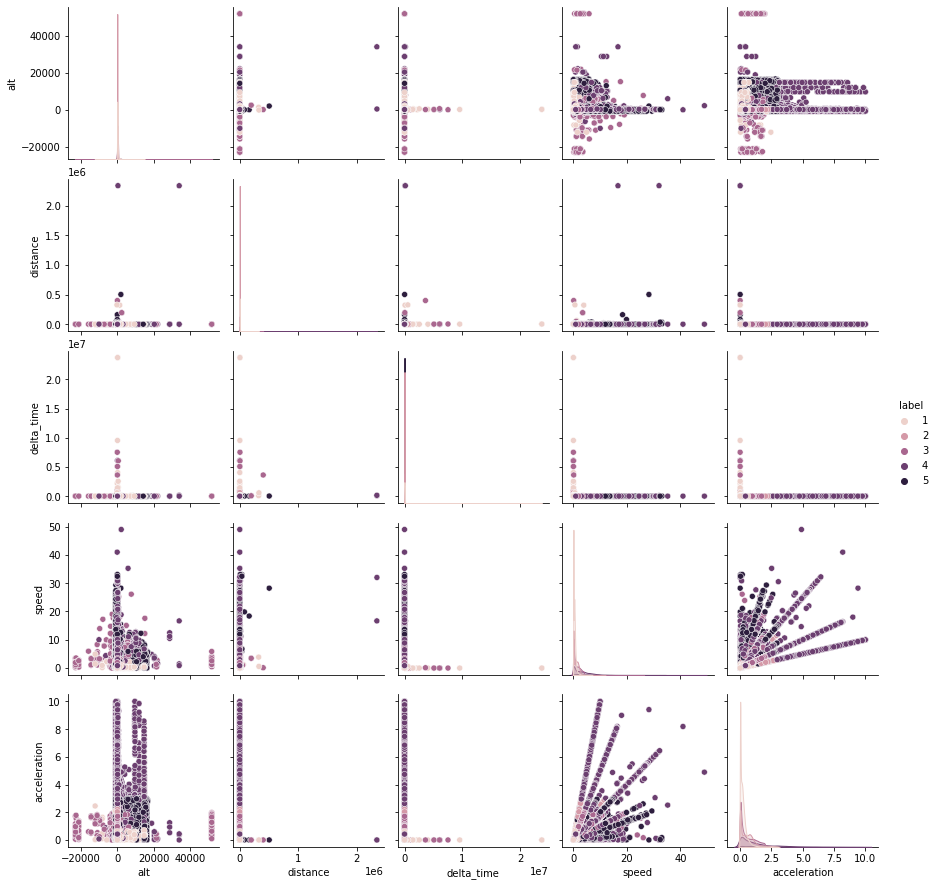

In [21]:
import seaborn as sns

visualizing_df = df7[['alt','distance','delta_time','speed','acceleration','label']].sample(frac=0.2, replace=True, random_state=1)
visualizing_df.reset_index(inplace=True)
visualizing_df.drop('index', axis=1, inplace=True)
sns.pairplot(visualizing_df, hue="label")

### Passo 9

In [22]:
from sklearn.model_selection import train_test_split

X = df7[['lat','lon','alt','distance','delta_time','speed','acceleration','trips','triplegs']]
y = df7[['label']].squeeze().tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.16, random_state=42)


### Passo 10.1

#### DecisionTree / No feature selection

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

start = datetime.datetime.now()

depths = [2,3,5]
cv_results = []
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf,X_val,y_val)
    cv_results.append(scores)
    
end = datetime.datetime.now()
print('Tempo gasto:',end-start)

cv_results

Tempo gasto: 0:01:04.860533


[array([0.49131869, 0.48941703, 0.49057572, 0.49357415, 0.49072608]),
 array([0.55458654, 0.55348093, 0.55348977, 0.55610787, 0.55381703]),
 array([0.66139803, 0.65910719, 0.65981479, 0.66100885, 0.660487  ])]

#### Random Forest / No feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start = datetime.datetime.now()

depths = [2,3,5]
cv_results = []
for d in depths:
    clf = RandomForestClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf,X_val,y_val)
    cv_results.append(scores)
    
end = datetime.datetime.now()
print('Tempo gasto:',end-start)

cv_results

### Passo 10.2

#### Feature Selection

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# X_new = SelectKBest(f_classif, k=5).fit_transform(X,y)

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
#     X_new, y, test_size=0.2, random_state=42)

# X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
#     X_train_new, y_train_new, test_size=0.16, random_state=42)

#### DecisionTree / With feature selection

In [ ]:
# start = datetime.datetime.now()

# depths = [2,3,5]
# cv_results = []
# for d in depths:
#     clf = DecisionTreeClassifier(max_depth=d)
#     clf.fit(X_train_new, y_train_new)
#     scores = cross_val_score(clf,X_val_new,y_val_new)
#     cv_results.append(scores)
    
# end = datetime.datetime.now()
# print('Tempo gasto no passo 10:',end-start)

# cv_results

#### Random Forest / With feature selection

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# start = datetime.datetime.now()

# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                     max_depth=1, random_state=0).fit(X_train_new, y_train_new)

# end = datetime.datetime.now()
# print('Tempo gasto GBoost:',end-start)

# clf.score(X_test, y_test)

### Passo 10.3

#### XGBoost

In [ ]:
# import xgboost as xgb

# param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax' }
# num_round = 2
# bst = xgb.train(param, X_train, num_round)
# # make prediction
# preds = bst.predict(X_test)

# cross_val_score(bst,X_test,y_test)